In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange

In [2]:
def f(x):
    if 1 <= x <= 3:
        return 1
    if -4.5 <= x <= -2.5:
        return (np.sin(np.pi * x) + 1) / 2
    
    if x < -5:
        return f(x+10) # for periodicity
    if x > 5:
        return f(x-10) # for periodicity
    
    return 0

def ff(xx):
    return np.array([f(x) for x in xx])

# Flux limiter

In [3]:
def upwind(theta):
    return 0 # 6.39a

def LaxWendroff(theta):
    return 1 # 6.39a

def vanLeer(theta):
    # 6.39b
    if theta == np.inf:
        return 2 # limit as theta => inf
    
    return (theta + abs(theta)) / (1 + abs(theta))

In [4]:
# Eq 6.40 & 6.41
def step_right(QQ, nu, phi=LaxWendroff):
    Q_next = np.zeros_like(QQ) # make a vector to store the result
    
    def Q(i): # easier periodic boundaries
        # mode="wrap" means we can access elements outside of the range and it wraps around to the other end
        return np.take(QQ, i, mode="wrap") 
        
    
    def delta_Q(i): # Eq. 6.31
        left = int(i)
        right = int(i+1)
        return Q(right) - Q(left) 
    
    for i in range(len(Q_next)):
        if abs(delta_Q(i - 0.5)) < 1e-10: # avoid divide by zero
            theta_left = np.inf
        else:
            theta_left = delta_Q(i - 1.5) / delta_Q(i - 0.5) # 6.35, u > 0
        
        if abs(delta_Q(i + 0.5)) < 1e-10: # avoid divide by zero
            theta_right = np.inf
        else:
            theta_right = delta_Q(i - 0.5) / delta_Q(i + 0.5) # 6.35, u > 0
        # equation 6.40, u > 0, nu < 0
        Q_next[i] = Q(i) - nu * (Q(i) - Q(i-1)) - 0.5 * nu * (1 - nu) * (phi(theta_right) * (Q(i+1) - Q(i)) - phi(theta_left) * (Q(i) - Q(i-1)))
    
    return Q_next

def step_left(QQ, nu, phi=LaxWendroff):
    Q_next = np.zeros_like(QQ) # make a vector to store the result
    
    def Q(i): # easier periodic boundaries
        return np.take(QQ, i, mode="wrap")
    
    def delta_Q(i): # Eq. 6.31
        left = int(i)
        right = int(i+1)
        return Q(right) - Q(left) 
    
    for i in range(len(Q_next)):
        if abs(delta_Q(i - 0.5)) < 1e-10:
            theta_left = np.inf
        else:
            theta_left = delta_Q(i + 0.5) / delta_Q(i - 0.5) # 6.35, u < 0
        
        if abs(delta_Q(i + 0.5)) < 1e-10:
            theta_right = np.inf
        else:
            theta_right = delta_Q(i + 1.5) / delta_Q(i + 0.5) # 6.35, u < 0
        # equation 6.41, u < 0, nu < 0
        Q_next[i] = Q(i) - nu * (Q(i+1) - Q(i)) + 0.5 * nu * (1 + nu) * (phi(theta_right) * (Q(i+1) - Q(i)) - phi(theta_left) * (Q(i) - Q(i-1)))
    
    return Q_next

# advection equation

In [5]:
def get_solutions_advection(dx=0.1, dt=0.04, n_periods=5, method=LaxWendroff):
    x_left = -5
    x_right = 5

    u = 1
    N = int((x_right - x_left) / dx + 0.5)
    dx = (x_right - x_left) / N
    nu = u * dt / dx

    steps_per_period = (x_right - x_left) / u / dt
    print("steps per period:", steps_per_period)
    steps_per_period = int(steps_per_period + 0.5)

    X = np.linspace(x_left, x_right, N, endpoint=False) + 0.5 * dx 
    # the last term is to get every point in the center of each volume

    Q0 = ff(X)

    
    print(f"CFL: {nu:.1f}")
    print(f"timesteps: {steps_per_period}" )
    
    Q = Q0
    QQ = []
    for i in trange(n_periods * steps_per_period + 1):
        if i % steps_per_period == 0:
            QQ.append(Q)
        Q = step_right(Q, nu, method)
    
    return X, QQ


In [54]:
10/0.04

250.0

steps per period: 400.0
CFL: 0.5
timesteps: 400


  0%|          | 0/2001 [00:00<?, ?it/s]

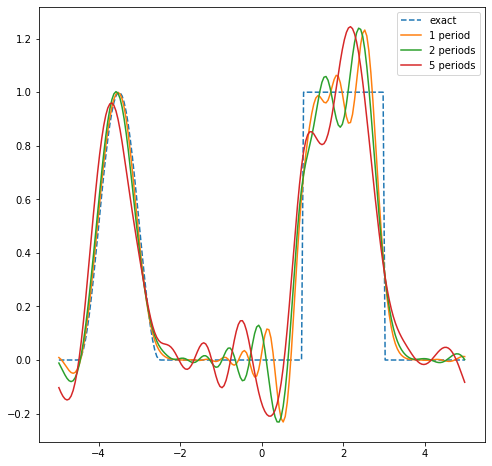

In [6]:
X, qq = get_solutions_advection(0.05, 0.025, 5, LaxWendroff)
plt.figure(figsize=(8,8))
plt.plot(X, qq[0], '--', label="exact")
plt.plot(X, qq[1], label="1 period")
plt.plot(X, qq[2], label="2 periods")
plt.plot(X, qq[5], label="5 periods")
plt.legend()
plt.savefig("img/LaxWendroff_advection_CFL0.5.png")

steps per period: 400.0
CFL: 0.5
timesteps: 400


  0%|          | 0/2001 [00:00<?, ?it/s]

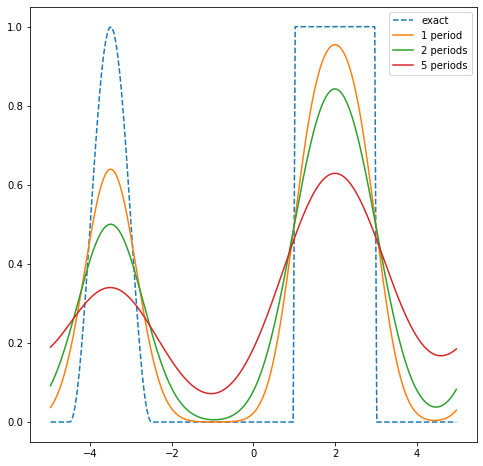

In [7]:
X, qq = get_solutions_advection(0.05, 0.025, 5, upwind)
plt.figure(figsize=(8,8))
plt.plot(X, qq[0], '--', label="exact")
plt.plot(X, qq[1], label="1 period")
plt.plot(X, qq[2], label="2 periods")
plt.plot(X, qq[5], label="5 periods")
plt.legend()
plt.savefig("img/upwind_advection_CFL0.5.png")

steps per period: 400.0
CFL: 0.5
timesteps: 400


  0%|          | 0/2001 [00:00<?, ?it/s]

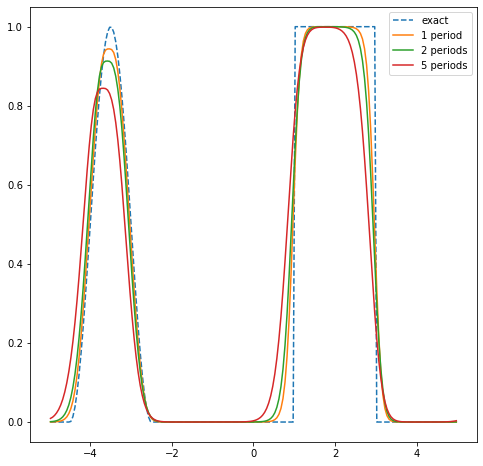

In [8]:
X, qq = get_solutions_advection(0.05, 0.025, 5, vanLeer)
plt.figure(figsize=(8,8))
plt.plot(X, qq[0], '--', label="exact")
plt.plot(X, qq[1], label="1 period")
plt.plot(X, qq[2], label="2 periods")
plt.plot(X, qq[5], label="5 periods")
plt.legend()
plt.savefig("img/vanLeer_advection_CFL0.5.png")

steps per period: 60.0
CFL: 0.3
timesteps: 60


  0%|          | 0/301 [00:00<?, ?it/s]

steps per period: 60.0
CFL: 0.3
timesteps: 60


  0%|          | 0/301 [00:00<?, ?it/s]

steps per period: 60.0
CFL: 0.3
timesteps: 60


  0%|          | 0/301 [00:00<?, ?it/s]

steps per period: 120.0
CFL: 0.3
timesteps: 120


  0%|          | 0/601 [00:00<?, ?it/s]

steps per period: 120.0
CFL: 0.3
timesteps: 120


  0%|          | 0/601 [00:00<?, ?it/s]

steps per period: 120.0
CFL: 0.3
timesteps: 120


  0%|          | 0/601 [00:00<?, ?it/s]

steps per period: 300.0
CFL: 0.3
timesteps: 300


  0%|          | 0/1501 [00:00<?, ?it/s]

steps per period: 300.0
CFL: 0.3
timesteps: 300


  0%|          | 0/1501 [00:00<?, ?it/s]

steps per period: 300.0
CFL: 0.3
timesteps: 300


  0%|          | 0/1501 [00:00<?, ?it/s]

steps per period: 600.0
CFL: 0.3
timesteps: 600


  0%|          | 0/3001 [00:00<?, ?it/s]

steps per period: 600.0
CFL: 0.3
timesteps: 600


  0%|          | 0/3001 [00:00<?, ?it/s]

steps per period: 600.0
CFL: 0.3
timesteps: 600


  0%|          | 0/3001 [00:00<?, ?it/s]

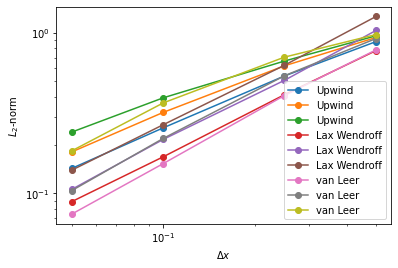

In [128]:
def get_err(dx, CFL, method=LaxWendroff):
    X, qq = get_solutions_advection(dx, CFL * dx, 5, method)
    
    err1 = np.linalg.norm(dx * (qq[1] - qq[0]), 2)
    err2 = np.linalg.norm(dx * (qq[2] - qq[0]), 2)
    err5 = np.linalg.norm(dx * (qq[5] - qq[0]), 2)
    return err1, err2, err5

dxs = [0.5, 0.25, 1/10, 1/20]
CFL = 1/3

err_upwind = []
err_lw = []
err_vl = []
for dx in dxs:
    err_upwind.append(get_err(dx, CFL, upwind))
    err_lw.append(get_err(dx, CFL, LaxWendroff))
    err_vl.append(get_err(dx, CFL, vanLeer))
    
    
plt.loglog(dxs, np.array(err_upwind), label='Upwind', marker='o')
plt.loglog(dxs, np.array(err_lw), label='Lax Wendroff', marker='o')
plt.loglog(dxs, np.array(err_vl), label='van Leer', marker='o')
plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$L_2$-norm")
plt.legend()

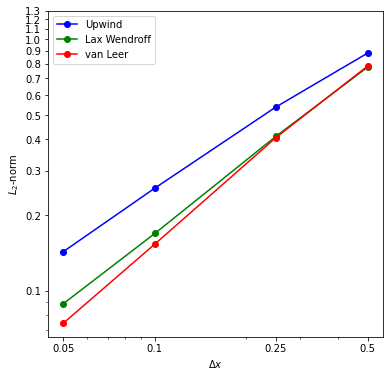

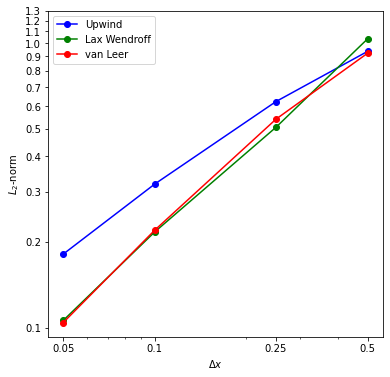

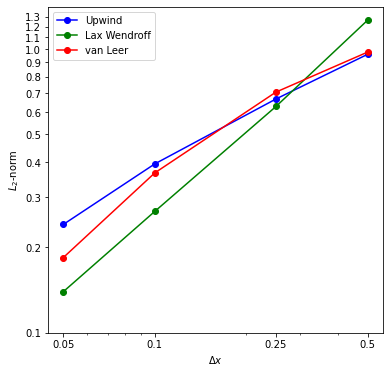

In [129]:
xt = dxs
xl = dxs

yt = None
yl = None

yt = np.arange(0.1, 1.4, 0.1)
yl = [f"{y:.1f}" for y in yt]


plt.figure(figsize=(6,6))
plt.plot(dxs, np.array(err_upwind)[:,0], label='Upwind', marker='o', color='blue')
plt.plot(dxs, np.array(err_lw)[:,0], label='Lax Wendroff', marker='o', color='green')
plt.loglog(dxs, np.array(err_vl)[:,0], label='van Leer', marker='o', color='red')
plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$L_2$-norm")

plt.xticks(dxs, dxs)
if yt is not None:
    plt.yticks(yt, yl)
plt.legend()
plt.savefig(f"img/advection_CFL{CFL:.2f}_period1.png")



plt.figure(figsize=(6,6))
plt.plot(dxs, np.array(err_upwind)[:,1], label='Upwind', marker='o', color='blue')
plt.plot(dxs, np.array(err_lw)[:,1], label='Lax Wendroff', marker='o', color='green')
plt.loglog(dxs, np.array(err_vl)[:,1], label='van Leer', marker='o', color='red')
plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$L_2$-norm")

plt.xticks(dxs, dxs)
if yt is not None:
    plt.yticks(yt, yl)
plt.legend()
plt.savefig(f"img/advection_CFL{CFL:.2f}_period2.png")



plt.figure(figsize=(6,6))
plt.plot(dxs, np.array(err_upwind)[:,2], label='Upwind', marker='o', color='blue')
plt.plot(dxs, np.array(err_lw)[:,2], label='Lax Wendroff', marker='o', color='green')
plt.loglog(dxs, np.array(err_vl)[:,2], label='van Leer', marker='o', color='red')
plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$L_2$-norm")

plt.xticks(dxs, dxs)
if yt is not None:
    plt.yticks(yt, yl)
plt.legend()
plt.savefig(f"img/advection_CFL{CFL:.2f}_period5.png")


# Wave equation

In [9]:
def vf(xx):
    return np.array([(f(x), 1) for x in xx])

# this is a vector function, it takes the x positions and returns the initial condition (p(x,0), u(x, 0)) for each point

In [10]:

def get_Q_acoustic(N=100, dt=0.05):
    x_left = -5
    x_right = 5

    u = 2
    dx = (x_right - x_left) / N
    nu = u * dt / dx

    steps_per_period = (x_right - x_left) / u / dt
    print("steps per period:", steps_per_period)
    print("CFL:", nu)

    X = np.linspace(x_left, x_right, N, endpoint=False) + 0.5 * dx

    # the last term is to get every point in the center of each volume
    Q0 = vf(X)

    # c, V = np.linalg.eig(A)
    # V = V * np.sqrt(5)
    c = np.array([2,-2]) # Eigenvalues of A
    V = np.array([
        [-2, 2], 
        [ 1, 1]
    ]) # Eigenvectors of A
    Vinv = np.linalg.inv(V) # V^-1

    Q_right0, Q_left0 = Vinv @ vf(X).T # transform the system in a purely left-moving and purely right-moving wave
    return V, Q_right0, Q_left0, int(steps_per_period + 0.5)

def solve_acoustic(V, Q_r0, Q_l0, period, nu, method=upwind, n_periods=5):
    Q_right = Q_r0
    Q_left = Q_l0

    Q = []
    for i in trange(period * n_periods + 1):
        if i % period == 0:
            Q.append((V @ np.array([Q_right,Q_left])))
        
        Q_right = step_right(Q_right, nu, method)
        Q_left = step_left(Q_left, -nu, method)
    return Q

def get_err_acoustic(dx, CFL, method=LaxWendroff):
    u = 2
    N = int(10 / dx + 0.5)
    dx = 10 / N
    dt = dx * CFL / u
    V, Q_right0, Q_left0, period = get_Q_acoustic(N, dt)
    qq = solve_acoustic(V, Q_right0, Q_left0, period, CFL, n_periods=5, method=method)

    
    err1 = np.linalg.norm(dx * (qq[1] - qq[0]), 2)
    err2 = np.linalg.norm(dx * (qq[2] - qq[0]), 2)
    err5 = np.linalg.norm(dx * (qq[5] - qq[0]), 2)
    return err1, err2, err5


In [11]:
dxs = [0.5, 0.25, 1/10, 1/20]

err_upwind = []
err_lw = []
err_vl = []
CFL = 1.25
for dx in dxs:
    err_upwind.append(get_err_acoustic(dx, CFL, upwind))
    err_lw.append(get_err_acoustic(dx, CFL, LaxWendroff))
    err_vl.append(get_err_acoustic(dx, CFL, vanLeer))
    

steps per period: 16.0
CFL: 1.25


  0%|          | 0/81 [00:00<?, ?it/s]

steps per period: 16.0
CFL: 1.25


  0%|          | 0/81 [00:00<?, ?it/s]

steps per period: 16.0
CFL: 1.25


  0%|          | 0/81 [00:00<?, ?it/s]

steps per period: 32.0
CFL: 1.25


  0%|          | 0/161 [00:00<?, ?it/s]

steps per period: 32.0
CFL: 1.25


  0%|          | 0/161 [00:00<?, ?it/s]

steps per period: 32.0
CFL: 1.25


  0%|          | 0/161 [00:00<?, ?it/s]

steps per period: 80.0
CFL: 1.25


  0%|          | 0/401 [00:00<?, ?it/s]

steps per period: 80.0
CFL: 1.25


  0%|          | 0/401 [00:00<?, ?it/s]

steps per period: 80.0
CFL: 1.25


  0%|          | 0/401 [00:00<?, ?it/s]

steps per period: 160.0
CFL: 1.25


  0%|          | 0/801 [00:00<?, ?it/s]

steps per period: 160.0
CFL: 1.25


  0%|          | 0/801 [00:00<?, ?it/s]

steps per period: 160.0
CFL: 1.25


  0%|          | 0/801 [00:00<?, ?it/s]

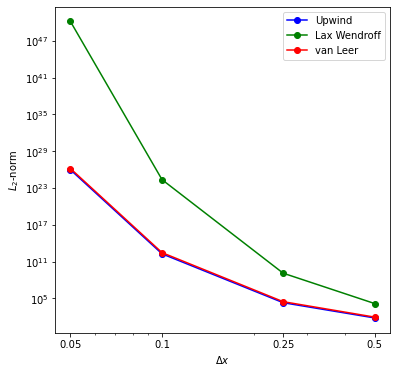

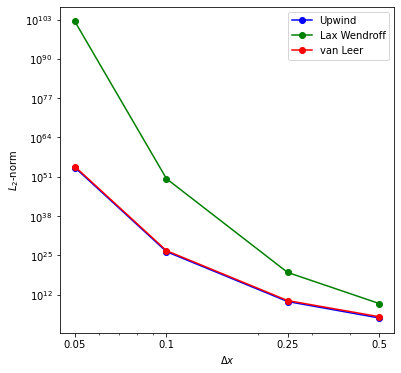

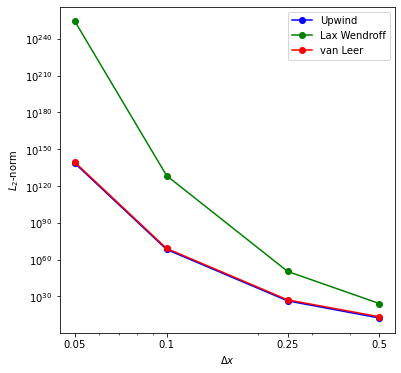

In [12]:
xt = dxs
xl = dxs

yt = None
yl = None

# yt = np.arange(0.1, 1, 0.1)
# yl = [f"{y:.1f}" for y in yt]


plt.figure(figsize=(6,6))
plt.plot(dxs, np.array(err_upwind)[:,0], label='Upwind', marker='o', color='blue')
plt.plot(dxs, np.array(err_lw)[:,0], label='Lax Wendroff', marker='o', color='green')
plt.loglog(dxs, np.array(err_vl)[:,0], label='van Leer', marker='o', color='red')
plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$L_2$-norm")

plt.xticks(dxs, dxs)
if yt is not None:
    plt.yticks(yt, yl)
plt.legend()
plt.savefig(f"img/wave_CFL{CFL:.2f}_period1.png")



plt.figure(figsize=(6,6))
plt.plot(dxs, np.array(err_upwind)[:,1], label='Upwind', marker='o', color='blue')
plt.plot(dxs, np.array(err_lw)[:,1], label='Lax Wendroff', marker='o', color='green')
plt.loglog(dxs, np.array(err_vl)[:,1], label='van Leer', marker='o', color='red')
plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$L_2$-norm")

plt.xticks(dxs, dxs)
if yt is not None:
    plt.yticks(yt, yl)
plt.legend()
plt.savefig(f"img/wave_CFL{CFL:.2f}_period2.png")



plt.figure(figsize=(6,6))
plt.plot(dxs, np.array(err_upwind)[:,2], label='Upwind', marker='o', color='blue')
plt.plot(dxs, np.array(err_lw)[:,2] * [1, 1, 1, 1e-5], label='Lax Wendroff', marker='o', color='green')
plt.loglog(dxs, np.array(err_vl)[:,2], label='van Leer', marker='o', color='red')
plt.xlabel(r"$\Delta x$")
plt.ylabel(r"$L_2$-norm")

plt.xticks(dxs, dxs)
if yt is not None:
    plt.yticks(yt, yl)
plt.legend()
plt.savefig(f"img/wave_CFL{CFL:.2f}_period5.png")


In [16]:

def get_solutions_acoustic(dx, CFL, method=LaxWendroff):
    u = 2
    N = int(10 / dx + 0.5)
    dx = 10 / N
    dt = dx * CFL / u
    V, Q_right0, Q_left0, period = get_Q_acoustic(N, dt)
    qq = solve_acoustic(V, Q_right0, Q_left0, period, CFL, n_periods=5, method=method)
    
    return qq

dx = 0.05
X = np.linspace(-5, 5, int(0.5+10/dx), endpoint=False) + 0.5 * dx


steps per period: 400.0
CFL: 0.5


  0%|          | 0/2001 [00:00<?, ?it/s]

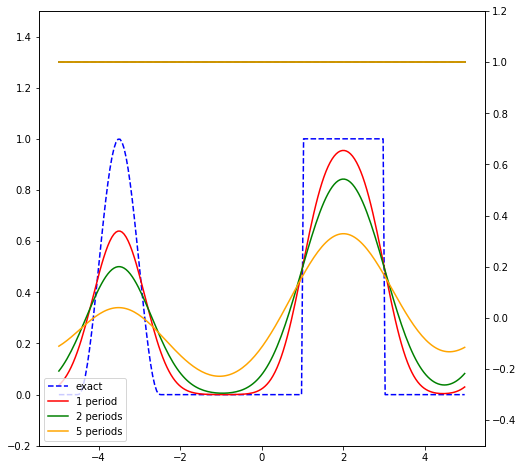

In [40]:
try:
    qq = qq_up
except:
    qq_up = get_solutions_acoustic(0.05, 0.5, upwind)
    qq = qq_up

plt.figure(figsize=(8,8))
plt.plot(X, qq[0][0], '--', color='blue', label="exact")
plt.plot(X, qq[1][0], color='red', label="1 period")
plt.plot(X, qq[2][0], color='green', label="2 periods")
plt.plot(X, qq[5][0], color='orange', label="5 periods")

plt.ylim(-.2, 1.5)

plt.twinx()

# plt.figure(figsize=(8,8))
plt.plot(X, qq[0][1], '--', color='blue', label="exact")
plt.plot(X, qq[1][1], color='red', label="1 period")
plt.plot(X, qq[2][1], color='green', label="2 periods")
plt.plot(X, qq[5][1], color='orange', label="5 periods")

plt.ylim(-.5, 1.2)

plt.legend()
plt.savefig("img/upwind_wave_CFL0.5.png")

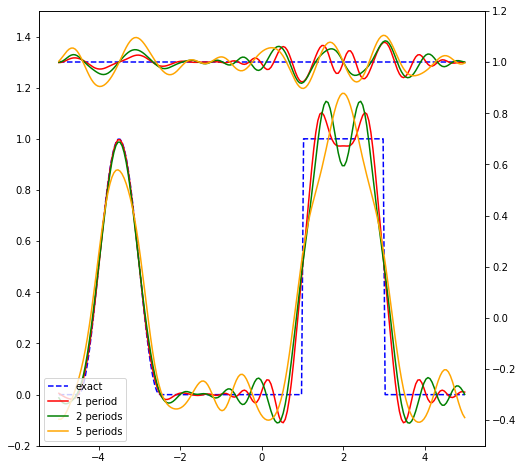

In [48]:
try:
    qq = qq_lw
except:
    qq_lw = get_solutions_acoustic(0.05, 0.5, LaxWendroff)
    qq = qq_lw

plt.figure(figsize=(8,8))
plt.plot(X, qq[0][0], '--', color='blue', label="exact")
plt.plot(X, qq[1][0], color='red', label="1 period")
plt.plot(X, qq[2][0], color='green', label="2 periods")
plt.plot(X, qq[5][0], color='orange', label="5 periods")

# plt.legend()
# plt.savefig("img/LaxWendroff_wave_CFL0.5_a.png")

plt.ylim(-.2, 1.5)


plt.twinx()

# plt.figure(figsize=(8,8))
plt.plot(X, qq[0][1], '--', color='blue', label="exact")
plt.plot(X, qq[1][1], color='red', label="1 period")
plt.plot(X, qq[2][1], color='green', label="2 periods")
plt.plot(X, qq[5][1], color='orange', label="5 periods")

plt.ylim(-.5, 1.2)

plt.legend()
plt.savefig("img/LaxWendroff_wave_CFL0.5.png")

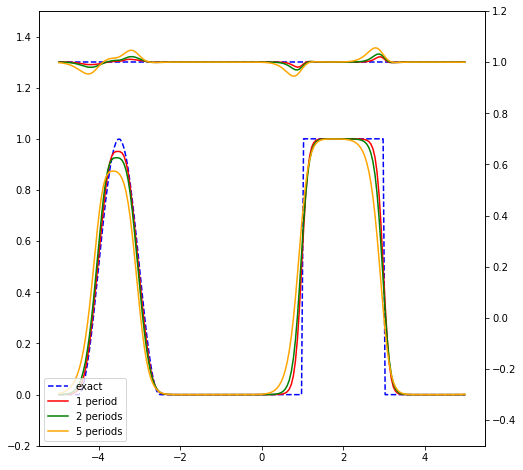

In [52]:
try:
    qq = qq_vl
except:
    qq_vl = get_solutions_acoustic(0.05, 0.5, vanLeer)
    qq = qq_vl

plt.figure(figsize=(8,8))
plt.plot(X, qq[0][0], '--', color='blue', label="exact")
plt.plot(X, qq[1][0], color='red', label="1 period")
plt.plot(X, qq[2][0], color='green', label="2 periods")
plt.plot(X, qq[5][0], color='orange', label="5 periods")

plt.ylim(-.2, 1.5)

plt.twinx()

# plt.figure(figsize=(8,8))
plt.plot(X, qq[0][1], '--', color='blue', label="exact")
plt.plot(X, qq[1][1], color='red', label="1 period")
plt.plot(X, qq[2][1], color='green', label="2 periods")
plt.plot(X, qq[5][1], color='orange', label="5 periods")

plt.ylim(-.5, 1.2)

plt.legend()
plt.savefig("img/vanLeer_wave_CFL0.5.png")